# DATASET DE IMAGENES DE MNIST





In [5]:
import tensorflow as tf, numpy as np, cv2
from google.colab.patches import cv2_imshow

In [6]:
#mnist cogerá las imágenes de entrenamiento de una librería
mnist = tf.keras.datasets.mnist
#x_train cogerá las imágenes de entrenamiento y y_train las etiquetas
#x_test y y_test serán las imágenes y las etiquetas de prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
x_train.shape
#Nos dice que hay 60000 imágenes de 28x28

(60000, 28, 28)

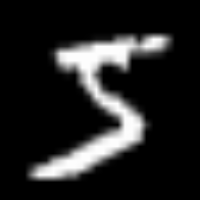

In [8]:
cv2_imshow(cv2.resize(x_train[0], (200,200)))
#Muestra la primera imagen y la resizea para que sea de 200x200 en vez de 28x28

In [9]:
y_train[0]
#Devuelve la etiqueta de la imagen

np.uint8(5)

In [10]:
x_test.shape
#Vamos a probar con 10000 imágenes sin etiquetar que el sistema nunca ha visto

(10000, 28, 28)

# DATASET DE CARACTERÍSTICAS CON HOG FEATURES

In [11]:
'''
Tenemos que preparar una forma de representar las imágenes en números
que sean útiles para un algoritmo de aprendizaje automático
Como una imagen es simplemente una matriz de píxeles esto resulta más complicado
de generalizar para la máquina (determinar que se ve en cada imagen)
Ejemplo: Una imagen con un 8 puede ser distinta a otra con un 8 distinto
Una forma de solucionarlo es con el HOG (Histogram of Oriented Gradients)
El HOG hace lo siguiente:
1º Detecta bordes y gradientes de la imagen (los píxeles del borde y que es
dentro y que es fuera)
2º Divide la imagen en pequeñas celdas (cellSize) y dentro de estas mide en que
dirección están los bordes
3º Agrupa celdas en bloques (blockSize) y normaliza los histogramas para que no dependa del
brillo o contraste de la imagen
4º Concatena los histogramas y lo convierte en un vector largo de características
Este vector representa la forma y textura de la imagen
De esta manera se consiguen 3 cosas:
- Resaltar las formas y bordes en los píxeles exactos
- Robustez ante los cambios de iluminación
- Compacta la información en solo un vector largo
'''
#Se coge una imagen
img = x_train[1]

def getHog():
  #Tamaño de la ventana de análisis (se va a analizar toda la imagen)
  winSize = img.shape
  #Tamaño del bloque de celdas (se va a ir en secciones de 8x8 píxeles)
  blockSize = (8,8)
  #Tamaño del desplazamiento del bloque de celdas (se va a mover de 2 en 2)
  #De esta manera se solaparán unos análisis de celdas con otras y podrá comparar
  blockStride = (2,2)
  #Tamaño de la celda dentro del bloque (cada celda será de 4x4)
  cellSize = (4,4)
  #Cantidad de barras del histograma (entre que valor y que valor se cuenta para una frecuencia)
  nbins = 9
  #Extrae vectores de características de la imagen que podremos usar después en un clasificador
  hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
  return hog

#Extraemos el modelo hog
hog = getHog()
#Aplicamos el modelo del hog a la imagen
hog.compute(img)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [12]:
def getFeatureDataset(x):
  #Hacemos un array de características
  features = []

  #Para cada imagen del array
  for img in x:
    #Obtenemos su vector de características
    #Y lo añadimos al array de características
    features.append(hog.compute(img).flatten())
  #Transformamos ese array en un numpy array
  features = np.array(features)
  return features


In [13]:
#Guardamos los arrays de características para los arrays de train y de test
features_train = getFeatureDataset(x_train)
features_test = getFeatureDataset(x_test)

# DEFINICIÓN E IMPLEMENTACIÓN DE LA RED NEURONAL

In [14]:
'''
Una NEURONA ARTIFICIAL recibe un vector de características x y se multiplican por los pesos w
Su fórmula es sum(w * x) + wb donde wb es el valor de w para x = 1
1 sola neurona solo puede dar una respuesta lineal, es decir, hayar la recta, plano o hiperplano
que separa el espacio de características en dos clases
Pero esto se puede complicar añadiendo más neuronas
Tiene una primera capa de caraterísticas o de entrada que recibe los vectores de características
Luego tiene una capa oculta de neuronas que es la primera capa de neuronas
Todas las capas que se encuentre entre la capa de entrada y la de salida serán capas ocultas
Después tiene una capa de salida donde se hace la clasificación final y devuelve
un vector de salida, que dará una respuesta u otra
Dependiendo de la salida que queramos podemos usar distintos tipos:
- sigmoid (entre 0 y 1) = 1 / (1 + e**(-x))
- tanh (entre -1 y 1) = tanh(x)
- ReLU (entre 0 y x) = max(0, x) Cuando la salida es continua
'''
'''
Los parámetos de una RED NEURONAL son:
- Cantidad de capas ocultas
- Cantidad de neuronas en cada capa
- Función de activación
- Método de optimización para minimizar el error en la clasificación
Una función de costo mide la diferencia de error entre la predicción y el valor real
Hay 2 funciones de costo principales:
- Con la función de ERROR CUADRÁTICO MEDIO (ems) podemos calcular el posible error
  Tiene esta forma:
  (1/2) * sum(w * x - y)**2
  Siendo w los pesos, x los vectores de características y y el valor real
  Queremos aumentar la w para que al multiplicarla por la x de algo muy parecido
  a la y por lo que al restarlos sea lo más cercano a 0
  Se eleva a 2 para quitar el signo
- Con la función de CATEGORICAL CROSS ENTROPY también podemos calcularlo
  Tiene esta forma:
  -sum,i(sum,clase(yi,clase * log Pclase * (w * xi)))
  Siendo:
  P la salida de la red neuronal (entre 0 y 1)
  w los pesos
  x los vectores de características
  y el valor real
En conclusión siempre querremos buscar los pesos w óptimos
Para ello definimos la función de costo que vamos a usar y el método de optimización
'''
#Convertimos las etiquetas enteras a vectores de onehot
#Ejemplo: Etiqueta 3 ==> Vector OneHot [0,0,0,1,0,0,0,0,0,0] (de 0 a 9)
y_trainOneHot = tf.one_hot(y_train, np.max(y_train) + 1)
y_testOneHot = tf.one_hot(y_test, np.max(y_train) + 1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Se define la red neuronal
def classifier():
  #Se construye la red (model) como una pila lineal de capas
  model = Sequential()
  #Primera capa con 200 neuronas, el número de características por muestra (input_dim) y método de activación relu
  model.add(Dense(200, input_dim = features_train.shape[1], activation = 'relu'))
  #Capa oculta con menos neuronas para más profundidad
  model.add(Dense(180, activation = 'relu'))
  #Lo mismo que la anterior
  model.add(Dense(150, activation = 'relu'))
  #Capa de salida con 10 neuronas que suman 1 en total, solo puede haber una correcta
  model.add(Dense(10, activation = 'softmax'))
  #Fija la función de pérdida y el optimizador
  model.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-3), #También se puede poner simplemente 'adam'
                metrics = ['accuracy'])
  return model

In [16]:
#Instanciamos el modelo
model = classifier()
#Muestra un resumen de la cantidad de parámetros que vamos a usar
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │       871,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 180)            │        36,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        27,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,240 (3.57 MB)

 Trainable params: 936,240 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
'''
Entrenamiento de la red neuronal
Consiste en que va a ir ajustando los pesos w de las neuronas para que el modelo
aprenda a relacionar features_train (X) con y_trainOneHot (Y)
features_train son los vectores de características de las imágenes
y_trainOneHot son los vectores de salida esperados
epochs es el número de veces que el modelo va a ver el dataset (10 vueltas enteras)
batch_size es la cantidad de imágenes que va a procesar en cada paso (va por lotes)
'''
model.fit(features_train, y_trainOneHot, epochs = 10, batch_size = 100)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2344 - loss: 2.2654
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5831 - loss: 2.0293
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7474 - loss: 1.6044
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8599 - loss: 1.0680
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9084 - loss: 0.6736
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9254 - loss: 0.4688
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9342 - loss: 0.3591
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9441 - loss: 0.2911
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9489 - loss: 0.2488
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9515 - loss: 0.2225


In [18]:
#Para evaluar el sistema entrenado
#Asigna a cada valor un array de caracteristicas
prediction_train = model.predict(features_train)
prediction_test = model.predict(features_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [19]:
#Devuelve el mayor peso de cada array de características
y_pred_train = np.argmax(prediction_train,1)
y_pred_test = np.argmax(prediction_test,1)

In [20]:
y_pred_train

array([5, 0, 4, ..., 5, 6, 8])

In [21]:
#Esto devuelve un vector que devuelve verdadero al error cuando no coinciden
#Luego lo hace en porcentaje de error
error_train = 100 * np.sum(y_pred_train != y_train) / len(y_train)
error_test = 100 * np.sum(y_pred_test != y_test) / len(y_test)

In [22]:
print("error de entrenamiento es: {}%".format(error_train))
print("error de prueba es: {}%".format(error_test))

error de entrenamiento es: 4.6033333333333335%
error de prueba es: 4.24%


# CÁLCULO DE LA MATRIZ DE CONFUSIÓN

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
#Se haya la matríz de confusión que se ve en que se ha equivocado concretamente el sistema
conf_mat = confusion_matrix(y_test, y_pred_test)

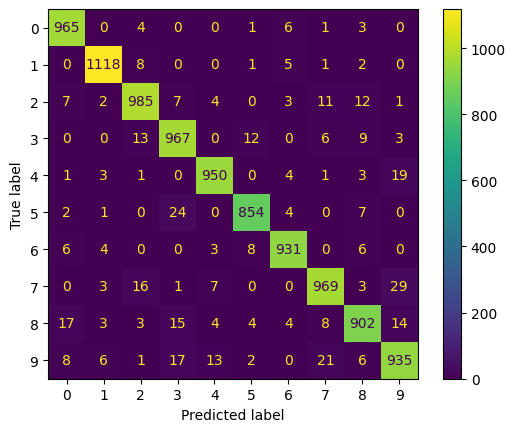

In [25]:
#Se grafica la tabla de confusión
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat)
disp.plot()

In [26]:
#Normalizamos la matriz para ver que porcentajes han fallado
conf_mat_norm = np.round(100 * conf_mat / np.sum(conf_mat,1),1)

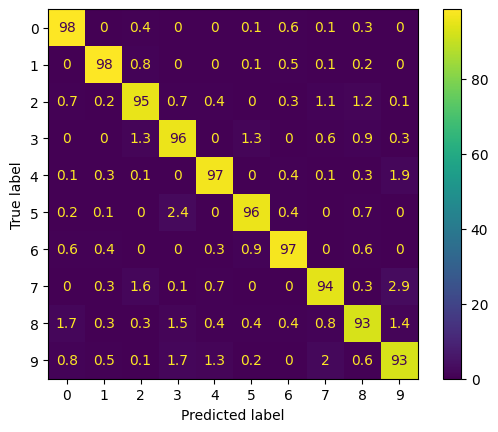

In [27]:
disp2 = ConfusionMatrixDisplay(confusion_matrix = conf_mat_norm)
disp2.plot()

# PRUEBA CON MI PROPIA IMAGEN

In [39]:
#Subimos una imagen desde el ordenador
from google.colab import files
up = files.upload()
filename = list(up.keys())[0]
print("Archivo subido:", filename)


Saving 4.jpg to 4 (1).jpg
Archivo subido: 4 (1).jpg


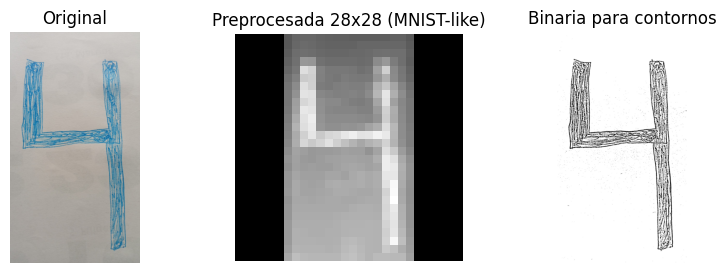

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicción: 4
Probabilidades: [0.006 0.018 0.028 0.132 0.474 0.056 0.004 0.037 0.17  0.074]


In [40]:
#Preprocesamos + HOG + Predicción
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

winSize = (28, 28)
blockSize = (8, 8)
blockStride = (2, 2)
cellSize = (4, 4)
nbins = 9
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

def preprocess_to_mnist_like(img_bgr, target_size=(28,28), invert=True):
    #Lo convertimos a escala de grises
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    #Binarizamos la imagen para detectar dígito
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 35, 11)

    #Encontramos los bordes
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        raise ValueError("No se detectó ningún contorno. Asegúrate de que el dígito sea claro.")
    c = max(cnts, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    crop = gray[y:y+h, x:x+w]

    #Lo hacemos cuadrado con padding y reescalamos a target_size
    side = max(w, h)
    pad_top = (side - h) // 2
    pad_bottom = side - h - pad_top
    pad_left = (side - w) // 2
    pad_right = side - w - pad_left
    squared = cv2.copyMakeBorder(crop, pad_top, pad_bottom, pad_left, pad_right,
                                 cv2.BORDER_CONSTANT, value=255)  # fondo blanco
    resized = cv2.resize(squared, target_size, interpolation=cv2.INTER_AREA)

    if invert:
        resized = 255 - resized

    if resized.dtype != np.uint8:
        resized = resized.astype(np.uint8)

    return resized, thr, (x,y,w,h), squared

#Cargamos la imagen subida
img_bgr = cv2.imread(filename)
if img_bgr is None:
    raise ValueError("No se pudo leer la imagen. Prueba con otro archivo.")

proc, thr, bbox, squared = preprocess_to_mnist_like(img_bgr, target_size=winSize[::-1], invert=True)

#Visualizamos el preprocesado
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(proc, cmap='gray'); plt.title("Preprocesada 28x28 (MNIST-like)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(thr, cmap='gray'); plt.title("Binaria para contornos"); plt.axis('off')
plt.show()

#Extrahemos HOG con los MISMOS parámetros que usamos al entrenar
f = hog.compute(proc).reshape(1, -1)   # (1, N_features)

#Hacemos la predicción
probs = model.predict(f)
pred = probs.argmax(axis=1)[0]
print("Predicción:", pred)
print("Probabilidades:", np.round(probs[0], 3))
